In [1]:
# import needed packages
import pretty_midi
import pypianoroll
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import random
import sys
import skimage.io as io
import matplotlib.pyplot as plt

In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:5")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '3,4,5'

## Data Analysis/Visualization

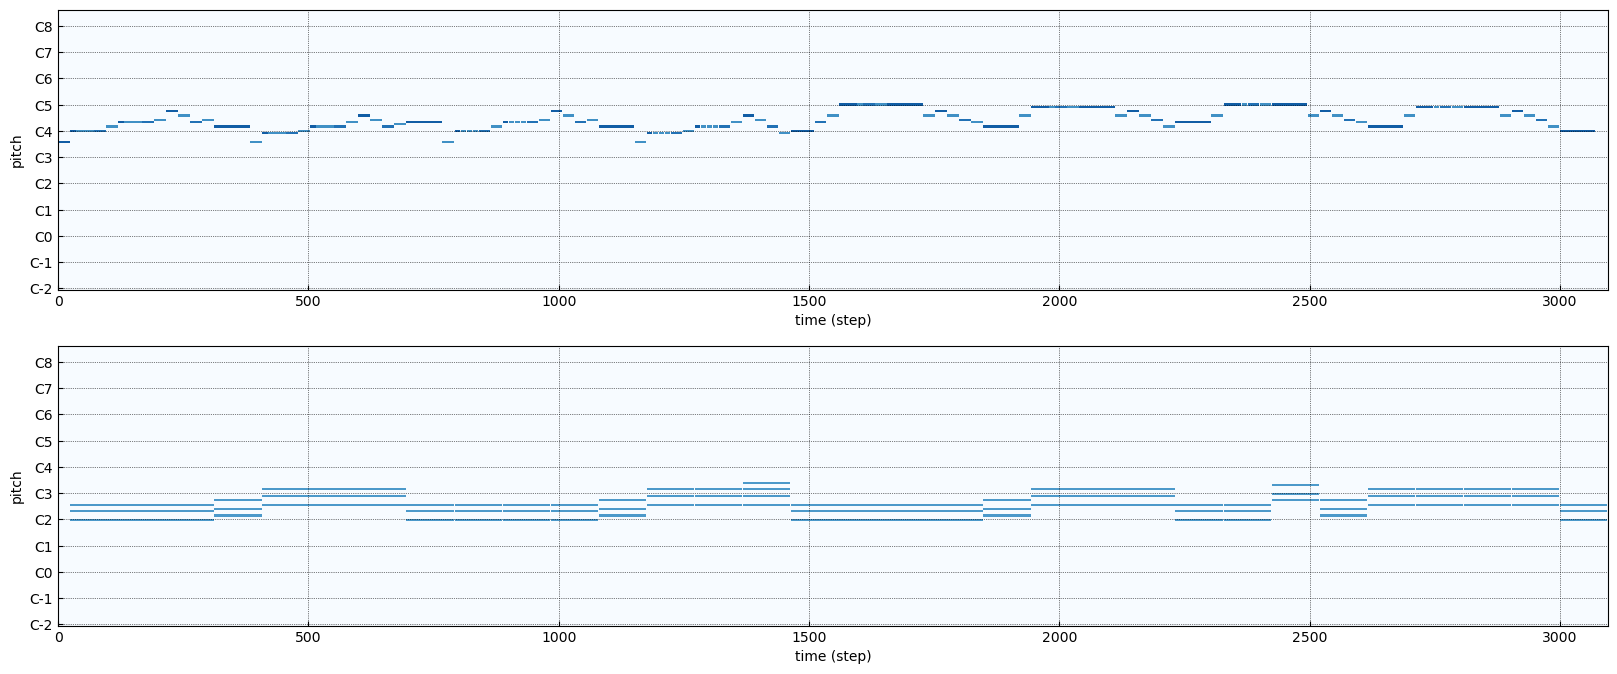

In [4]:
# read in midi file
multitrack = pypianoroll.read("data/nottingham/train/reels_simple_chords_27.mid")
# get right and left hand piano rolls
righthand = multitrack.tracks[0].pianoroll
lefthand = multitrack.tracks[1].pianoroll
# plot them to check
fig, axs = plt.subplots(nrows=2, figsize=(20,8))
pypianoroll.plot_pianoroll(pianoroll=righthand, ax=axs[0])
pypianoroll.plot_pianoroll(pianoroll=lefthand, ax=axs[1])

## Helper Functions

(128, 3096)


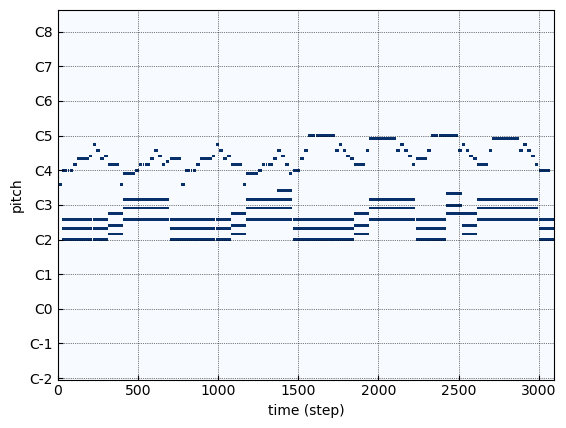

In [5]:
def midi_filename_to_piano_roll(midi_filename):
    # convert multitrack midi to one numpy array
    multitrack = pypianoroll.read(midi_filename).binarize()
    piano_roll = multitrack.tracks[0].pianoroll
    for track in multitrack.tracks[1:]:
        piano_roll = np.maximum(piano_roll, track.pianoroll)
    # return (128, length of song) matrix
    return piano_roll.transpose()

def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    # We hardcode 128 -- because we will always use only 128 pitches
    padded_piano_roll = np.zeros((128, 17688))
    padded_piano_roll[:] = pad_value
#     print('original length', piano_roll.shape, padded_piano_roll.shape)
    padded_piano_roll[:, :piano_roll.shape[1]] = piano_roll
    return padded_piano_roll

pianoroll = midi_filename_to_piano_roll("data/nottingham/train/reels_simple_chords_27.mid")
print(pianoroll.shape)
fig, axs = plt.subplots()
pypianoroll.plot_pianoroll(pianoroll=pianoroll.transpose(), ax=axs)

In [6]:
class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        self.midi_folder_path = midi_folder_path
        midi_filenames = os.listdir(midi_folder_path)
        self.longest_sequence_length = longest_sequence_length
        midi_full_filenames = list(map(lambda filename: os.path.join(midi_folder_path, filename),
                                  midi_filenames))
        self.midi_full_filenames = midi_full_filenames
        
        if longest_sequence_length is None:
            self.update_the_max_length()
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = list(map(lambda filename: pypianoroll.read(filename).get_max_length(),
                                self.midi_full_filenames))
        max_length = max(sequences_lengths)
        self.longest_sequence_length = max_length
        print("THE LONGEST SEQUENCE LENGTH IS", max_length)
    
    def __len__(self):
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        midi_full_filename = self.midi_full_filenames[index]
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        # Shifted by one time step

        # excludes the last column (timestep)
        input_sequence = piano_roll[:, :-1]
        # excludes the first column (timestep)
        ground_truth_sequence = piano_roll[:, 1:]
        # pad sequence so that all of them have the same length
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]))

In [7]:
trainset = NotesGenerationDataset('data/nottingham/train/')

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=30,
                                              shuffle=True, num_workers=4, drop_last=True)

valset = NotesGenerationDataset('data/nottingham/valid/', longest_sequence_length=None)

valset_loader = torch.utils.data.DataLoader(valset, batch_size=10, shuffle=False, num_workers=4, drop_last=False)

/home/aliciawang/miniconda3/envs/lofi-bytes/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


THE LONGEST SEQUENCE LENGTH IS 17688


In [8]:
def post_process_sequence_batch(batch_tuple):
    '''
    Sort batch by sequence lengths and preprocess for training
    '''
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    # sort all the splitted sequences by their length
    training_data_tuples = zip(splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch)
    training_data_tuples_sorted = sorted(training_data_tuples, key=lambda p: int(p[2]), reverse=True)
    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lengths to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = list(map(lambda x: int(x), lengths_batch_sorted_list))
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list

In [9]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]
        notes_encoded = self.notes_encoder(input_sequences)
        
        # Here we run rnns only on non-padded regions of the batch
        # Why? https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
        # TLDR optimizes computations and tells RNN what is the batch size at each time step
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        logits = logits.transpose(0, 1).contiguous()
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [10]:
rnn = RNN(input_size=128, hidden_size=512, num_classes=128)
rnn = rnn.half()
rnn = rnn.to(device)

criterion = nn.CrossEntropyLoss().to(device)

criterion_val = nn.CrossEntropyLoss(reduction='sum').to(device)

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [18]:
from tqdm import tqdm

loss_list = []
val_list = []

clip = 1.0
epochs_number = 10000
best_val_loss = float("inf")

for epoch_number in tqdm(range(epochs_number)):

    for batch in tqdm(trainset_loader):

        process_batch = post_process_sequence_batch(batch)
        input_sequences_batch, output_sequences_batch, sequences_lengths = process_batch
        output_sequences_batch_var =  Variable(output_sequences_batch.contiguous().view(-1).to(device))
        input_sequences_batch_var = Variable(input_sequences_batch.to(device))
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
    
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:
        process_batch = post_process_sequence_batch(batch)
        input_sequences_batch, output_sequences_batch, sequences_lengths = process_batch
        output_sequences_batch_var =  Variable(output_sequences_batch.contiguous().view(-1).to(device))
        input_sequences_batch_var = Variable(input_sequences_batch.to(device))
        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    current_val_loss = full_val_loss / (overall_sequence_length * 128)
    val_list.append(current_val_loss)

    if current_val_loss < best_val_loss:
        torch.save(rnn.state_dict(), 'music_rnn.pth')
        best_val_loss = current_val_loss
        
    if epoch_number % 10 == 0:
        print('Epoch: {}  Loss: {} %'.format(epoch_number, 0))

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_20540/3192413851.py:26: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

  0%|          | 0/10000 [00:35<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.09 GiB (GPU 5; 15.89 GiB total capacity; 10.87 GiB already allocated; 499.88 MiB free; 14.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF